In [218]:
import pandas as pd
import datetime 
import time
import numpy as np
from matplotlib import pyplot as plt, rcParams

import ast
import io
import webbrowser
from random import shuffle

import brtdevkit
from brtdevkit.core.db import DBConnector, DatetimeFilter
from brtdevkit.core.db.db_filters import *  # We need this for pre-defined filters, e.g., ProjectFilter, DatetimeFilter

# Function to query Aletheia for an image DF

def get_shasta_data(filters={}, start=None, end=None, limit=None):
    """
    Query Shasta metadata matching filters and date.
    """
    start_time = time.time()
    connector = DBConnector()
    img_filters = {'project_name': 'shasta', **filters}
    if start is not None or end is not None:
        img_filters = [img_filters, DatetimeFilter(key="collected_on", start=start, end=end)]
    df = connector.get_documents_df('image', img_filters, limit=limit)
    elapsed_time = time.time() - start_time
    return df, elapsed_time

In [209]:
import datetime
from timezonefinder import TimezoneFinderL
import pytz
from pysolar.solar import *

tf = TimezoneFinderL()

def get_solar_angle(timestamp, latitude, longitude):
    """
    Requires datetime, TimezonefinderL, pytz and pysolar libraries
    
    Inputs: Timestamp, latitude, longitude.
    Outputs: Solar angle between (-90 , 90). Daylight conditions will always be > 0.
    """
    # Localize and adjust UTC timestamps to local timezone
    utc = pytz.utc.localize(timestamp)
    tz = tf.timezone_at(lat=latitude, lng=longitude)
    adjusted_timestamp = utc.astimezone(tz)

    # If there are invalid GPS coordinates, the function will return 'NaN'
    if adjusted_timestamp.tzinfo is not None:
        return get_altitude(latitude, longitude, adjusted_timestamp)
    else:
        return float('NaN')
    
fd['solar_angle'] = fd.apply(lambda x: get_solar_angle(x['collected_on'], x['latitude'], x['longitude']), axis=1)

/home/williamroberts/code/brtdevkit/venv/lib/python3.6/site-packages/pysolar/solartime.py:112: UserWarning: I don't know about leap seconds after 2018
  (leap_seconds_base_year + len(leap_seconds_adjustments) - 1)


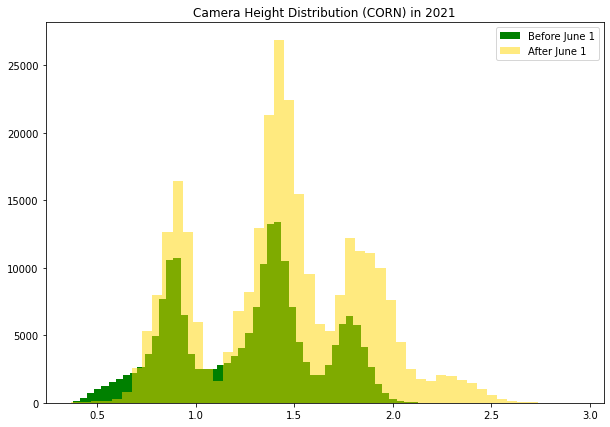

In [4]:
#What is the distribution of solar angles?
full_df['date_collected']= pd.to_datetime(full_df['collected_on']).dt.date
cam_heights = full_df[full_df['date_collected']>datetime(2021, 6, 1).date()]['camera_height']
solar2 = full_df[full_df['date_collected']<=datetime(2021, 6, 1).date()]['camera_height']
plt.figure(figsize=(10,7))
plt.hist(cam_heights, color = 'green', bins=50)#, alpha=0.5
plt.hist(solar2, color = 'gold', bins=50, alpha=0.5)
plt.title('Camera Height Distribution (CORN) in 2021')
plt.legend(['Before June 1', 'After June 1'])
#plt.savefig('since_mid_june_solar_angles.png', dpi=100)
plt.show()

### Graph for Q4 Demo

hits = [111, 213, 438]
goals = [600, 600, 600]
rcParams['font.size'] = 18

sns.set_style('white')

N = 3
ind = np.arange(N)  # the x locations for the groups
width = 0.35       # the width of the bars

plt.figure(figsize=(14,8))
ax=plt.subplot()
rects1 = ax.bar(ind, goals, width, color='powderblue')
rects2 = ax.bar(ind+width, hits, width, color='salmon')

ax.set_ylabel('Number of Unique Fields')
ax.set_title('2021 vs 2020 DCM Collection Goals')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(['Corn', 'Cotton','Soybeans'] )
ax.legend( (rects1[0], rects2[0]), ('2021 Goal', '2020 Fields'), loc=4)
plt.savefig('2021_field_imaging_goals.png', dpi=80)
plt.show()

In [208]:
cols = ['collected_on','latitude','longitude']
#sol_master = full_df[cols]
print(sol_master.shape)
fd = pd.concat([sm, full_df[cols]], axis=0)
fd.shape

(346799, 3)


(1518224, 3)

In [219]:
# Set date filters to return data collected between 03/01/2020 and 09/01/2020
start = datetime(2021,5,24) # First field was collected on 3/30
end = datetime(2021, 7, 25)

dcms_2021 = ['DCM11', 'DCM12', 'DCM13', 'DCM14','DCM16', 'DCM17','DCM18', 'DCM19', 'DCM20', 'DCM21','DCM22','DCM23','DCM24','DCM25', 'DCM26', 'DCM27', 'DCM28']
dbs_2021 = ['DB1', 'DB2', 'DB3', 'DB4', 'DB5', 'DB6', 'DB7', 'DB8', 'DB9']
updcms = ['DCM12', 'DCM13', 'DCM16', 'DCM33', 'DCM17', 'DCM20', 'DCM28', 'DCM27', 'DCM34', 'DCM26']
# Select filters
filters = { "artifacts.kind": "nrg",  
           'robot_name' :{"$in":updcms}
          }

full_df, elapsed_time = get_shasta_data(filters=filters, start = start, end = end)
full_df['date_collected'] = pd.to_datetime(full_df['collected_on']).dt.date
full_df['grower_farm_field'] = full_df['grower'] +'_' + full_df['farm'] + '_' + full_df['operating_field_name']
print(f"Queried {len(full_df)} images in {elapsed_time:.2f} s.")

Queried 615803 images in 376.94 s.


In [217]:
full_df= None

In [3]:
infield = ['infield_labeling_cotton_1', 'Infield_labeling', 'inield_labeling', 
           'inield_labeling_soy_1','inield_labeling_soy_2', 'inield_labeling_soy_3', 
           'inield_labeling_cotton', 'infield_labeling', 'In field labeling']

paths = full_df[full_df['experiment_id'].isin(infield)].s3_path.unique()

codes =  [p.split('2021-')[1][0:14] for p in paths]
np.unique(codes)

array(['06-16_21-04-04'], dtype='<U14')

In [226]:
full_df.groupby(['crop_name', 'has_human_annotation']).size()

crop_name               has_human_annotation
CORN                    False                    91229
                        True                       602
COTTON                  False                   101391
                        True                      1853
NONE_FALLOW_PRE_EMERGE  False                      203
OTHER                   False                       64
SOYBEANS                False                   147976
                        True                      3481
dtype: int64

In [216]:
logs =  ['05-13_22-16-26', '05-13_22-50-35', '05-13_23-22-06', '05-13_23-42-39', '05-14_17-35-47', 
         '05-14_18-19-59', '05-14_19-37-06', '05-14_21-18-44', '06-01_16-08-32', '06-04_16-28-42', 
         '06-04_18-57-25', '06-04_19-31-34', '06-04_19-31-43', '06-10_18-19-02', '06-10_19-45-28', 
         '06-10_20-36-17', '06-15_14-54-58', '06-15_14-59-02', '06-15_15-22-34', '06-15_15-23-20', 
         '06-15_15-27-27', '06-15_15-31-06', '06-16_21-00-19']
print(len(logs))

n = 22
vpu= 14

path  = 's3://brt-dcm-data/db9/vpu0-'+ str(vpu) + 'a/full/2021-'+logs[n]
#print(path)
logs = [s for s in full_df.s3_path.unique() if s.split('.')[0]==path]
print(logs)
log_df = full_df[full_df['s3_path'].isin(logs)]

nrgs = list(log_df['_id'])
shuffle(nrgs)

webbrowser.open_new('https://aletheia.brtws.com/images/' + nrgs[0])
for i in range(1,12):
    webbrowser.open_new_tab('https://aletheia.brtws.com/images/' + nrgs[i])


23
['s3://brt-dcm-data/db9/vpu0-14a/full/2021-06-16_21-00-19.237840838_344_12466.923374850']


In [217]:
full_df = None

In [26]:
import webbrowser
from random import shuffle

#infield = ['infield_l_s_8', 'infield_l_s_10', 'infield_l_s_12','infield_l_s_15']
#full_df = full_df[full_df['experiment_id'].isin(infield)]

probable_paths = [s for s in full_df.s3_path.unique() if (s.split('vpu0-')[1].split('/full')[0]=='12a') or (s.split('vpu0-')[1].split('/full')[0]=='13a')]
#strs = [ s.split('vpu0-')[1].split('/full')[0] for s in full_df.s3_path.unique()]
#s = full_df.s3_path.unique()
s = probable_paths[1]
if_df = full_df[full_df['s3_path']==s]
print(if_df.experiment_id.unique()[0])
nrgs = list(if_df['_id'])
shuffle(nrgs)

#for i in range(12):
    #webbrowser.open_new_tab('https://aletheia.brtws.com/images/' + nrgs[i])
print(probable_paths)
#print(strs)

infield_l_s_8
['s3://brt-dcm-data/db4/vpu0-12a/full/2021-06-25_16-42-11.579376394_378_3441.922131415', 's3://brt-dcm-data/db4/vpu0-13a/full/2021-06-25_16-42-11.578334610_378_3441.847825945', 's3://brt-dcm-data/db4/vpu0-12a/full/2021-06-25_16-45-22.477290429_378_3632.820045418', 's3://brt-dcm-data/db4/vpu0-13a/full/2021-06-25_16-45-22.479998612_378_3632.749489819', 's3://brt-dcm-data/db4/vpu0-12a/full/2021-06-25_16-48-15.299608332_378_3805.642362809', 's3://brt-dcm-data/db4/vpu0-13a/full/2021-06-25_16-48-15.303974667_378_3805.573465938', 's3://brt-dcm-data/db4/vpu0-12a/full/2021-06-25_16-51-07.081680502_378_3977.424435491', 's3://brt-dcm-data/db4/vpu0-13a/full/2021-06-25_16-51-07.083757591_378_3977.353248766']


In [43]:
full_df.groupby(['crop_name', 'crop_height']).size()

crop_name               crop_height   
CORN                    LARGE              40463
                        MEDIUM             66316
                        SMALL              69366
COTTON                  LARGE               6530
                        MEDIUM             72249
                        SMALL              78723
NONE_FALLOW_PRE_EMERGE  NOT_APPLICABLE      3498
SOYBEANS                LARGE              11753
                        MEDIUM            104096
                        SMALL             130484
SUGARBEETS              SMALL               1198
dtype: int64

In [44]:
full_df[(full_df.crop_name == 'COTTON') & (full_df.crop_height=='LARGE')].grower_farm_field.value_counts()

travis senter_holthouse senter_bounds east               1334
freddy black_ra pickens_owens                            1261
joel brown_lawrence group_231& ee corner top             1240
josh baile_bailey farms_Jill's                           1197
tng land cattle_west gin burmac rd_west gin burmac rd    1167
josh bailey_bailey farms_Jill's                           331
Name: grower_farm_field, dtype: int64

In [145]:
flag_exp = ['flag capture bare', 'flag capture with few weeds',
       'flag capture with crop', 'flag bare', 'flag with few plants',
       'flag with few with crop']

flag = (full_df[full_df['experiment_id'].isin(flag_exp)])
print(len(flag))

hra = hra_df[hra_df['group_id'].isin(flag['group_id'])]
len(hra)

312


312

In [5]:
full_df.groupby(['grower_farm_field','crop_name']).size().groupby('crop_name').count()

crop_name
CORN                      181
COTTON                    125
NONE_FALLOW_PRE_EMERGE     22
OTHER                       8
SOYBEANS                  125
dtype: int64

In [45]:
(full_df.angle_to_row.value_counts() / len(full_df)) *100

PARALLEL          77.151434
ANGLED            12.545444
PERPENDICULAR     10.115799
NOT_APPLICABLE     0.171613
UNKNOWN            0.015709
Name: angle_to_row, dtype: float64

In [220]:
# https://docs.google.com/spreadsheets/d/15n7Q7Pike2tZPt3tCtFzltmsmHYHRa4A4zOp_dtb51o/edit?usp=sharing

from googleapiclient.discovery import build
from google_auth_oauthlib.flow import InstalledAppFlow,Flow
from google.auth.transport.requests import Request
import os
import pickle

SCOPES = ['https://www.googleapis.com/auth/spreadsheets']

# here enter the id of your google sheet
SAMPLE_SPREADSHEET_ID_input = '15n7Q7Pike2tZPt3tCtFzltmsmHYHRa4A4zOp_dtb51o'
SAMPLE_RANGE_NAME = 'A1:C1000'

def main():
    global values_input, service
    creds = None
    if os.path.exists('token.pickle'):
        with open('token.pickle', 'rb') as token:
            creds = pickle.load(token)
    if not creds or not creds.valid:
        if creds and creds.expired and creds.refresh_token:
            creds.refresh(Request())
        else:
            flow = InstalledAppFlow.from_client_secrets_file(
                'client_secret_548494862685-dsak7p6lj4ovilgl08fjlhknkb7f8umb.apps.googleusercontent.com.json', SCOPES) # here enter the name of your downloaded JSON file
            creds = flow.run_local_server(port=0)
        with open('token.pickle', 'wb') as token:
            pickle.dump(creds, token)

    service = build('sheets', 'v4', credentials=creds)

    # Call the Sheets API
    sheet = service.spreadsheets()
    result_input = sheet.values().get(spreadsheetId=SAMPLE_SPREADSHEET_ID_input,
                                range=SAMPLE_RANGE_NAME).execute()
    values_input = result_input.get('values', [])

    if not values_input and not values_expansion:
        print('No data found.')

main()

sheet_df=pd.DataFrame(values_input, columns=['grower', 'farm', 'operating_field_name'])
sheet_df['grower_farm_field'] = sheet_df['grower'] +'_' + sheet_df['farm'] + '_' + sheet_df['operating_field_name']
sheet_df.drop(0,inplace=True)
sheet_df.head()

,grower,farm,operating_field_name,grower_farm_field
1,CA skiles,Barton,2,CA skiles_Barton_2
2,brt test,college station parking,parking lot,brt test_college station parking_parking lot
3,Skiles Farm,Barton,B16,Skiles Farm_Barton_B16
4,Skiles,Barton,6,Skiles_Barton_6
5,Skiles,Barton,6,Skiles_Barton_6


In [221]:
new_fields = full_df[~full_df['grower_farm_field'].isin(sheet_df.grower_farm_field.unique())].groupby(['grower', 'farm', 'operating_field_name', 'crop_name','date_collected','robot_name','row_spacing']).size().reset_index()
#new_fields[['grower', 'farm', 'operating_field_name']]
new_fields.to_csv('new_fields.csv', index=False)
len(new_fields)

218

In [222]:
!pwd

/home/williamroberts/code/brtdevkit/Projects/R4 Data Collections


In [67]:
# compare these s

evaluated = pd.read_csv('evaluated.csv')
evaluated['grower_farm_field'] = evaluated['grower'] +'_' + evaluated['farm'] + '_' + evaluated['operating_field_name']
sheet_df[~sheet_df.grower_farm_field.isin(evaluated.grower_farm_field.unique())].to_csv('new_fields_to_eval.csv')

In [9]:
#Look at Satellite Overlay of Fields

import folium
import re
from PIL import Image
from PIL import ImageFont
from PIL import ImageDraw 
from warnings import filterwarnings
filterwarnings("ignore")

def get_visual_df(image_initial):
    visual_df = image_initial[['_id','crop_name','farm', 'operating_field_name',  'weed_pressure','latitude', 'longitude', 'collected_on', 'robot_name', 'angle_to_row']]
    
    # make a column for image id, with the type string
    # currently it is of the form objectID, which will cause issues later
    visual_df['img_id'] = visual_df['_id'].astype('str')
    
    # Create a link using the image id
    # dp_id should be changed to _id if working with the image dataframe
    visual_df['link'] = "https://aletheia.brtws.com/images/"+visual_df["img_id"]
    
    # Make the link clickable
    link_text = str(visual_df['link'])
    visual_df['test_link'] = folium.Html('<a href="' + visual_df['link'] +'"target="_blank">' + re.sub(r"[']+", "\\\\'", link_text[:45]) + '</a>', script=True)
    
    # Add it as a pop-up
    visual_df['popup'] = folium.Popup(visual_df['test_link']) 
    return visual_df

def get_map(visual_df, zoom_start=17, show_all=False):
    # Create a list of locations for plotting using the gps coordinates
    locations = visual_df[['latitude', 'longitude']]
    
    locationlist = locations.values.tolist()
    # create a base map
    # leave the zoom number low, e.g. 5 if you want a view of half the county
    # if you just want an area to cover a part of the state 10 is probably a good number
    # 13 is a good number if you just want to look at a field 
    # control scale adds a scale bar 
    map = folium.Map(location=locationlist[0], zoom_start=zoom_start, control_scale=True, max_zoom=26);

    # Make the link clickable
    link_text = str(visual_df['link'])
    if show_all == True:
        for i in visual_df.index:
            webbrowser.open_new(visual_df['link'][i]) 
    # add data points to map
    # we are adding clickable links to the points 
    # these links will direct you back to the original image in aletheia 
    for point in range(0, len(locationlist)):
        #print(locationlist[point])
        #print(visual_df['link'][point])
        
        # changed to location_list
        folium.Circle(locationlist[point], 
                      popup=folium.Popup(folium.Html('<a href="' + visual_df['link'].iloc[point] + '"target="_blank">' + re.sub(r"[']+", "\\\\'", link_text[:45]) +'</a>', script = True)), 
                      color = 'coral', radius = 0.3).add_to(map);
        
    return map

def add_satellite_overlay(map):
    # Create an overlay on satellite map
    tile = folium.TileLayer(
            tiles = 'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
            attr = 'Esri',
            name = 'Esri Satellite',
            overlay = False,
            control = True
           ).add_to(map)
    
def grab_img(map):
    img_data = map._to_png()
    return Image.open(io.BytesIO(img_data))

def add_text(img, text):
    draw = ImageDraw.Draw(img)
    # draw.text((x, y),"Sample Text",(r,g,b))
    draw.text((50, 0), text, (255,255,255))
    
def sample_n(df, n=25):
    df= df[(df['angle_to_row']=="PARALLEL")]
    shuffled_index = random.sample(list(df._id), n)
    sampled_df = df[df._id.isin(shuffled_index)]
    return sampled_df

def generate_overlay_image(data, df, zoom=16, show_all=False, sample=False):
    image_initial = df[(df.grower_farm_field == data)]
    
    print(len(image_initial))
    if sample == True:
        visual_df = get_visual_df(sample_n(image_initial))
    else:
        visual_df = get_visual_df(image_initial)
    map = get_map(visual_df, zoom_start=zoom, show_all=show_all)
    add_satellite_overlay(map)
    img = grab_img(map)
    print('\n')
    return map  


In [ ]:
full_df

In [121]:
this_field['angle_to_row'].value_counts()/len(this_field)*100

PERPENDICULAR    62.567812
ANGLED           37.432188
Name: angle_to_row, dtype: float64

In [40]:
pr = full_df[full_df['grower_farm_field'].isin(new_fields)].groupby(['grower_farm_field', 'robot_name', 'crop_name', 'date_collected', 'row_spacing']).size().reset_index()
pr = pr.sort_values(by='date_collected')
pr

,grower_farm_field,robot_name,crop_name,date_collected,row_spacing,0
2,Toby Robertson_Midnight Sun_1,DCM11,COTTON,2021-04-13,INCHES_30,1957
3,Toby Robertson_Midnight Sun_6,DCM11,COTTON,2021-04-13,INCHES_30,1719
0,Kuebler_Kuebler_L164,DCM15,SUGARBEETS,2021-04-21,CENTIMETERS_45,1388
1,Robin Kuemmerer_Kuemmerer_1,DCM15,OTHER,2021-04-29,CENTIMETERS_45,672
4,mark hamilton_hamilton farm_rock,DCM19,CORN,2021-05-27,INCHES_30,1092
5,mark hamilton_hamilton farms_front,DCM19,COTTON,2021-05-27,INCHES_30,1163


In [112]:
this_field.crop_name.value_counts()

SOYBEANS    1150
CORN        1075
Name: crop_name, dtype: int64

In [132]:

n = 836


x = sheet_df.grower_farm_field[n-1]
print(x)
this_field = full_df[(full_df['grower_farm_field']==x)]

mr = list(this_field['_id'])
shuffle(mr)
for i in range(5):
    webbrowser.open_new_tab('https://aletheia.brtws.com/images/' + mr[i])

print(this_field.collected_on[0])
print(this_field.robot_name.unique()[0])
print(this_field.operator_name.unique()[0])
print(this_field.experiment_id.unique())
print(this_field.notes.unique())
print(f'row spacing is: {this_field.row_spacing.unique()}')
print(this_field['angle_to_row'].value_counts())

generate_overlay_image(data = x, df = full_df)

tony wemhoff_wemhoff farms_lila
2021-06-01 14:21:32.524000
DCM23
parker nolan
['capture 1' 'capture 2' 'capture 3' 'capture 4' 'capture 4 actual data'
 'capture 5' 'capture 6' 'capture 7' 'capture 8' 'capture 9']
[nan 's curve row']
row spacing is: ['INCHES_30']
PARALLEL    1191
Name: angle_to_row, dtype: int64
1191




In [141]:
flag_exp = ['flag capture bare', 'flag capture with few weeds',
       'flag capture with crop', 'flag bare', 'flag with few plants',
       'flag with few with crop']

flag = (full_df[full_df['experiment_id'].isin(flag_exp)])[['grower', 'operating_field_name', '_id', 'experiment_id' ]]
flag._id

_id
60cc8ef44ecadd152b49feb9    60cc8ef44ecadd152b49feb9
60cc9bf198704bcc08de6aa0    60cc9bf198704bcc08de6aa0
60cc9ffd4d6591a3fca9d64b    60cc9ffd4d6591a3fca9d64b
60cc9a97c10c9245786f4640    60cc9a97c10c9245786f4640
60cc97c998704bcc08de4ee6    60cc97c998704bcc08de4ee6
                                      ...           
60cc9f328589c548ae81f1f5    60cc9f328589c548ae81f1f5
60cc996897a357a1a9767972    60cc996897a357a1a9767972
60cc92a6e6da58a89171b617    60cc92a6e6da58a89171b617
60cc9dedfa0a8a2cc0c8d32f    60cc9dedfa0a8a2cc0c8d32f
60cc99a998704bcc08de5cff    60cc99a998704bcc08de5cff
Name: _id, Length: 312, dtype: object

In [46]:
from geopy import distance
new_fields = full_df
#new_fields = new_fields[new_fields['robot_name']=='DCM13']

field_names = []
img_per_m = []
min_length = []
mean_length = []
max_length = []
n_collections = []
total_length = []
images = []
times = []
dcms = []
walking_speeds = []

for fn in new_fields.grower_farm_field.unique():
    field = new_fields[new_fields['grower_farm_field']==fn].sort_values(by='collected_on')
    dcms.append(field.robot_name.unique()[0])
    collections = []
    for cid in field.collection_id.unique():
        collection_info = field[field['collection_id']==cid]
        collection_info = collection_info.sort_values(by='collected_on')
        n = len(collection_info)
        first_lat_long = [collection_info.latitude[0], collection_info.longitude[0]]
        last_lat_long = [collection_info.latitude[n-1], collection_info.longitude[n-1]]
        collections.append(distance.distance(first_lat_long, last_lat_long).meters)
    field_names.append(fn)
    min_length.append(np.min(collections))
    max_length.append(np.max(collections))
    mean_length.append(np.median(collections))
    total_length.append(np.sum(collections))
    n_collections.append(len(collections))
    images.append(len(field))
    img_per_m.append(len(field)/np.sum(collections))
    total_time = field['collected_on'][0]
    for n in range(1,len(field)-1):
            first_time = field['collected_on'][n]
            last_time = field['collected_on'][n+1]
            timespan = (last_time - first_time)
            if (timespan.seconds < 220) and (timespan.seconds > 0):
                total_time = total_time + (timespan)
    times.append((total_time - field['collected_on'][0]).total_seconds()/60)
    walking_speeds.append(np.sum(collections)/(total_time - field['collected_on'][0]).total_seconds())

collection_lengths = pd.DataFrame({'Field Name': field_names, 'Collections': n_collections, 
                                   'Total Images': images, 'Images / m': img_per_m,
                                   'Total Length': total_length,'Min Length': min_length, 
                                   'Max Length':max_length, 'Median Length': mean_length,
                                   'Time Spent (min)': times, 'Walking Speed': walking_speeds, 'DCM': dcms
                                   })
#collection_lengths = collection_lengths.drop([42, 52, 53, 54]) # remove tests
collection_lengths[0:5]

,Field Name,Collections,Total Images,Images / m,Total Length,Min Length,Max Length,Median Length,Time Spent (min),Walking Speed,DCM
0,Allen Below_Section 20_9&10,9,1218,1.584455,768.718554,77.041866,89.993666,85.901503,7.458333,1.717807,DCM14
1,Allen Below_Section 20_1&2,9,1221,1.568643,778.379731,80.417517,91.349195,87.255351,5.466667,2.373109,DCM14
2,Allen Below_Section 20_5,9,1236,1.543482,800.786760,84.167005,93.854930,88.900915,5.083333,2.625530,DCM14
3,Andew Miller_Andrew Miller Farms_Sandridge 370...,1,162,2.043452,79.277624,79.277624,79.277624,79.277624,0.000000,inf,DCM12
4,Andrew Miller_Andrew Miller Farms_Espejo South...,9,1389,2.025908,685.618632,47.645782,85.562649,78.809460,13.208333,0.865134,DCM12


In [47]:
means = collection_lengths.groupby('DCM').median()
means.columns = ['Median Num Collections', 'Median Num Images per Field', 'Images / m', 'Total Length',
       'Min Length', 'Max Length', 'Median Length (m)', 'Time Spent Collecting (minutes)',
       'Walking Speed m/s']
means[['Median Num Collections', 'Median Num Images per Field','Median Length (m)', 'Time Spent Collecting (minutes)']]

,Median Num Collections,Median Num Images per Field,Median Length (m),Time Spent Collecting (minutes)
DCM,,,,
DCM11,9.0,1175.0,71.449204,11.258333
DCM12,9.0,1306.0,80.635693,11.225000
DCM13,9.0,1876.5,81.574937,6.135492
DCM14,9.0,1096.5,81.626483,7.211225
DCM16,9.0,1071.0,71.042673,13.841667
DCM17,9.0,1121.0,89.283925,8.308333
DCM18,9.0,1237.5,63.886567,12.680250
DCM19,9.0,1143.0,80.191904,9.283333
DCM20,9.0,1311.5,70.575823,9.833333


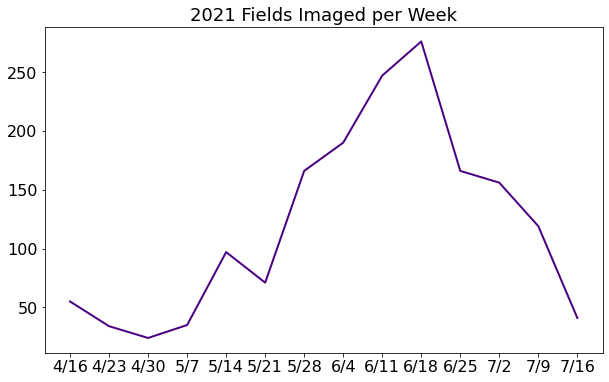

In [223]:
from matplotlib import pyplot as plt
fields = [55, 34, 24, 35, 97, 71, 166, 190, 247, 276, 166, 156, 119, 41]

dates = ['4/16', '4/23', '4/30', '5/7', '5/14', '5/21', '5/28', '6/4', '6/11', '6/18', '6/25', '7/2', '7/9', '7/16']

plt.figure(figsize=(10,6))
plt.title('2021 Fields Imaged per Week', fontsize=18)
plt.plot(dates, fields, linewidth=2, color ='indigo')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.savefig('2021_field_counts.png', dpi=100)
plt.show()